In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from typing_extensions import Protocol

from jax import grad
from jax import numpy as jnp
from jax.tree_util import register_pytree_node_class
from typing import NamedTuple 
from jax.config import config
config.update("jax_enable_x64", True)



@register_pytree_node_class
class ManifoldArray:
    """A lightweight wrapper for arrays constrained to mainfold. 
    It combines the `value` (a JAX PyTree) with a corresponding 'manifold'
    (Manifold object).
    """
    def __init__(self, value : jnp.array, manifold = None) -> None:
        self.value = value
        self.manifold = manifold

    def __repr__(self) -> str:
        return f"ManifoldParameter(value={self.value}, " \
               f"manifold={self.manifold})" \

    def tree_flatten(self):
        children = (self.value,)
        aux_data = self.manifold
        return children, aux_data

    @classmethod
    def tree_unflatten(cls, aux_data, children):
        return cls(children[0], aux_data)


def rgrad(f):
    "Riemannian Gradient Operator"
    def _temp(*args, **kwargs):
        g = args[0].manifold.egrad_to_rgrad(args[0],grad(f)(*args, **kwargs))
        g = ManifoldArray(g, args[0].manifold)
        return g 
    return _temp


class TransformInitFn(Protocol):
    def __call__(self, params):
        "The `init` function"    
   

class TransformUpdateFn(Protocol):
    def __call__(self, updates, state, params):
        "The `update` function."

class RiemannianGradientTransformation(NamedTuple):
    "Named Tuple representing Riemannian Gradient Transformation."
    init: TransformInitFn
    update: TransformUpdateFn


In [3]:
class EmptyState(NamedTuple):
  """An empty state for the simplest stateless transformations."""


ScaleState = EmptyState

def scale(step_size) :
  """Scale updates by some fixed scalar `step_size`."""

  def init_fn(params):
    del params 
    return ScaleState()

  def update_fn(updates, state, params=None):
    del params
    updates = step_size*updates.value   #jax.tree_util.tree_map(lambda g: step_size * g, updates)
    return updates, state

  return RiemannianGradientTransformation(init_fn, update_fn)

def apply_update(params, updates):
    """Applies an update to the corresponding parameters."""
    return ManifoldArray(params.manifold.exp(params,updates), p.manifold)

def _scale_by_learning_rate(learning_rate, flip_sign=True):
    m = -1 if flip_sign else 1
    return scale(m * learning_rate)


def rsgd(learning_rate):
    """Riemannian stochastic gradient descent."""
    return _scale_by_learning_rate(learning_rate)

def apply_updates(params, updates):
    #print("a", params.manifold)
    #print("b", updates.manifold)
    """Applies an update to the corresponding parameters."""
    
    return ManifoldArray(params.manifold.retr(params.value,updates), params.manifold)
    #return jax.tree_map(lambda p,u : ManifoldArray(p.manifold.exp(u), p.manifold), params, updates)

In [4]:
class GrassmannCanonical():
    def __init__(self, m, r):

        self.m = m
        self.r = r
        self.dim = m*r - r*r

    def exp(self, base_point, tangent_vec):
        u, s, vt = jnp.linalg.svd(tangent_vec, full_matrices=False)
        exp = (
            base_point @ (vt.T * jnp.cos(s).reshape(1, -1)) @ vt
            + (u * jnp.sin(s).reshape(1, -1)) @ vt
        )
        return exp

    def retr(self, base_point, tangent_vec):
        #print("a")
        u, _, vt = jnp.linalg.svd(base_point+tangent_vec, full_matrices=False)
        return u @ vt
        
    def log(self, base_point, point):
        ytx =point.T @ base_point
        At = point.T - ytx @ base_point.T
        Bt = jnp.linalg.solve(ytx, At)
        u, s, vt = jnp.linalg.svd(Bt.T, full_matrices=False)
        log = (u * jnp.arctan(s).reshape(1, -1)) @ vt
        return log

    def dist(self, point_a, point_b):
        s = jnp.clip(jnp.linalg.svd(point_a.T @ point_b, compute_uv=False), a_max=1.0)
        dist = jnp.linalg.norm(jnp.arccos(s))
        return dist

    def inner_product(self, base_point, tangent_vec_a, tangent_vec_b):
        ip = jnp.tensordot(tangent_vec_a, tangent_vec_b, axes=2)
        return ip

    def parallel_transport(self, start_point, end_point, tangent_vec):
        direction = self.log(start_point, end_point)
        u, s, vt = jnp.linalg.svd(direction, full_matrices=False)
        ut_delta = u.T @ tangent_vec  
        pt = (
            (
                start_point @ (vt.T * -1 * jnp.sin(s).reshape(1, -1))
                + (u * jnp.cos(s).reshape(1, -1))
            )
            @ (ut_delta)
            + tangent_vec
            - u @ (ut_delta)
        )
        return pt
    

    def egrad_to_rgrad(self, base_point, egrad):
        return self.projector(base_point, egrad)
        
    def projector(self, base_point, vec):
#         print("a", type)
#         print("b", vec.shape)
        return vec.value - base_point.value @(base_point.value.T @ vec.value)

In [5]:
import cv2
import glob
from tqdm import tqdm 

TRAINPATH = "../input/tiny-imagenet200zip/tiny-imagenet-200/train/*/images/*.JPEG"
images = [cv2.imread(file) for file in tqdm(glob.glob(TRAINPATH)[:5000])]
np_data = np.asarray(images[:5000], dtype=np.float64).reshape(5000,-1)/255
print(np_data.shape)
print(np_data.dtype)

100%|██████████| 5000/5000 [00:15<00:00, 328.87it/s]


(5000, 12288)
float64


In [12]:
import numpy as np
def qr_method(n, m, mean=0, sigma=1):
    X = np.random.normal(mean,sigma,(n,m))
    if n < m:
        X = X.T
    Q, _ = np.linalg.qr(X)
    
    if n < m:
        Q = Q.T
    return Q



In [13]:
number_of_components = [5,10]

In [14]:
def np_cost(U, Z):
    n = Z.shape[0]
    diff = Z.T - U @ (U.T @ Z.T)   # m,r @ r,m @ m, n => m,n
    cost = np.linalg.norm(diff)**2
    return cost/n

In [15]:
from jax import jit, vmap
from jax.numpy.linalg import norm

from timeit import default_timer as timer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter



#sns.set_style("whitegrid", {"axes.grid": False})
sns.set(style="ticks")
sns.set_style("darkgrid")



#markers = {"Rieoptax": "^", "Tf-Riemnopt": "H", "Implicit Basis": "D"}

In [16]:
number_of_components = [5]

In [17]:

for comp in number_of_components:
    

    pca = PCA(comp)
    pca.fit(np_data)
    final = pca.components_

    mean = (pca.mean_).reshape(1,-1)
    centered_np_data = np_data - mean
    jnp_centered_data = jnp.asarray(centered_np_data, dtype=jnp.float64)
    minimum_loss = np_cost(final.T,centered_np_data)
    print("min_loss", minimum_loss)
    
    r = comp
    n,m = centered_np_data.shape
    np.random.seed(0)
    np_init = qr_method(m,r)
    print(np_init)
    
    
    def fit(params, data, optimizer, epochs):
        @jit 
        def step(params, opt_state, data):

            def cost(params, data):
                def _cost(params, data):
                    return norm(data-params.value@(params.value.T @ data))**2
                return vmap(_cost, in_axes=(None,0))(params, data).mean()

            rgrads = rgrad(cost)(params, data) #calculates Riemannian gradients
            updates, opt_state = optimizer.update(rgrads, opt_state, params)
            params = apply_updates(params, updates) #Update using Riemannian Exp
            loss_value = cost(params, data)
            return params, opt_state, loss_value

        opt_state = optimizer.init(params)
        rieoptax_loss = []
        rieoptax_time = []
        rieoptax_loss.append(np_cost(params.value, data))
        rieoptax_time.append(0)
        start = timer()
        for i in tqdm(range(epochs)):
            params, opt_state, loss_value = step(params, opt_state, data)
            print("a", loss_value)
            elapsed_time = timer() - start
            rieoptax_loss.append(loss_value)
            rieoptax_time.append(elapsed_time)
            
        
        return rieoptax_loss, rieoptax_time
        
        #initialization
    jnp_init = jnp.asarray(np_init)
    
    U_init = ManifoldArray(value=jnp_init, manifold=GrassmannCanonical(m, r))
    
    epochs = 2000
    lr = 2e-3
    optimizer = rsgd(lr)
    rieoptax_loss, rieoptax_time = fit(U_init, jnp_centered_data, optimizer, epochs)
    
    #np.save("rieoptax_loss_{}_Retr.npy".format(r), rieoptax_loss)
#     np.save("rieoptax_time_{}_Retr.npy".format(r), rieoptax_time)
    
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
   
    axes.plot(np.asarray(rieoptax_time),  np.asarray(rieoptax_loss) - np.asarray(minimum_loss))
    axes.set_yscale("log")
    axes.set_xscale("log")
    plt.show()
    
    

min_loss 504.1261508270147
[[-0.01593932 -0.00379506 -0.00867057 -0.02026257 -0.01714275]
 [ 0.00883032 -0.00842038  0.00143458  0.00096335 -0.00365046]
 [-0.00130152 -0.0130762  -0.00667279 -0.0009889  -0.00415637]
 ...
 [ 0.00159498  0.01259631  0.00426733  0.00280454 -0.01155148]
 [ 0.00087732  0.01136757  0.02593819 -0.00956088  0.01484627]
 [-0.01200866 -0.00181394  0.0040975  -0.00681626  0.00839676]]


2022-10-08 11:01:28.706525: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-08 11:01:28.820228: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-10-08 11:01:29.895508: W external/org_tensorflow/tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 11.0.221, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to 

a 923.2572486763828
a 922.7950069685011
a 921.4514365820665
a 917.3838927556418
a 905.168982448368
a 871.9341730083675
a 805.2524099168588
a 737.1750413362204
a 712.303952138355
a 703.5240406029601
a 692.4641551015139
a 677.6825732437095
a 661.2116130173839
a 646.7268276311017
a 636.7464120902755


  1%|▏         | 25/2000 [00:03<02:20, 14.03it/s]

a 631.0197689259287
a 627.8983503229218
a 625.9617637785077
a 624.3886023099257
a 622.7539524773595
a 620.8229539080834
a 618.4416818379043
a 615.4937740700834
a 611.891109218545
a 607.5807136705333
a 602.5569490590676
a 596.8703174056286
a 590.6266925488089
a 583.9759414161522
a 577.0946327051041


  2%|▏         | 41/2000 [00:03<01:11, 27.57it/s]

a 570.1687165226024
a 563.3773524955902
a 556.8749188001328
a 550.7715734616015
a 545.1203568439762
a 539.9202725531225
a 535.1363847110459
a 530.7275279850103
a 526.6687233904563
a 522.959922392863
a 519.6204984787149
a 516.6751628551211
a 514.1392579047587
a 512.0095710637996
a 510.2627361945215


  3%|▎         | 57/2000 [00:03<00:46, 41.94it/s]

a 508.85957508482505
a 507.75208669224895
a 506.89018704706916
a 506.2266399917288
a 505.7198597868927
a 505.33497134826905
a 505.04372618793934
a 504.8238066366712
a 504.6578920750597
a 504.53270869770427
a 504.43817322513536
a 504.36667184824427
a 504.3124779893134
a 504.27129484025767
a 504.2399024608719


  4%|▎         | 73/2000 [00:04<00:35, 54.00it/s]

a 504.21588889203065
a 504.1974469913237
a 504.1832217815923
a 504.1721961668865
a 504.1636055612624
a 504.1568741921464
a 504.1515675977005
a 504.14735719887204
a 504.14399386483757
a 504.14128817404327
a 504.13909566044913
a 504.1373057730433
a 504.13583360306603
a 504.13461367595283
a 504.1335952851208


  4%|▍         | 89/2000 [00:04<00:30, 62.31it/s]

a 504.13273897845414
a 504.1320139076334
a 504.1313958242168
a 504.13086556120976
a 504.13040787963917
a 504.1300105900215
a 504.1296638812358
a 504.1293598061952
a 504.1290918863172
a 504.1288548062081
a 504.12864417703827
a 504.12845635235806
a 504.12828828407436
a 504.12813740928306
a 504.12800156089264


  5%|▌         | 105/2000 [00:04<00:28, 67.23it/s]

a 504.1278788966605
a 504.12776784254015
a 504.1276670471983
a 504.1275753452886
a 504.1279685347677
a 504.12750605278967
a 504.12739849538315
a 504.127319968157
a 504.12725218370775
a 504.12719189518486
a 504.1271375200164
a 504.12708804699355
a 504.12704276009345
a 504.12700111687167
a 504.1271077690002


  6%|▌         | 113/2000 [00:04<00:27, 68.78it/s]

a 504.1269490581982
a 504.12690722352806
a 504.1268738976095
a 504.12684363659724
a 504.1268157215523
a 504.12678980728055
a 504.12676565084104
a 504.12674306336606
a 504.12672189021896
a 504.12670200060256
a 504.12668328151176
a 504.1266656338965
a 504.1266489700444
a 504.12663321169134
a 504.12661828859234


  6%|▋         | 129/2000 [00:04<00:26, 70.75it/s]

a 504.1266041374088
a 504.1265907008138
a 504.1265779267615
a 504.1265657678771
a 504.1265541809428
a 504.126543126457
a 504.1265325682545
a 504.12652247317493
a 504.12651281077177
a 504.12650355305675
a 504.126494674271
a 504.1264861506831
a 504.12647796040756
a 504.12647008324177
a 504.12646250052006


  7%|▋         | 145/2000 [00:04<00:25, 71.77it/s]

a 504.1264551949816
a 504.126448150651
a 504.12644135273064
a 504.1264347875029
a 504.1264284422411
a 504.1264223051286
a 504.1264163651858
a 504.1264106122021
a 504.12640503667575
a 504.12639962975777
a 504.1263943832001
a 504.12638928930966
a 504.1263843409054
a 504.12637953127893
a 504.1263748541584


  8%|▊         | 161/2000 [00:05<00:25, 72.29it/s]

a 504.12637030367586
a 504.12636587433667
a 504.1263615609918
a 504.1263573588121
a 504.1263532632647
a 504.1263492700915
a 504.12634537528925
a 504.1263415750904
a 504.1263378659474
a 504.12633424451616
a 504.1263307076416
a 504.126327252345
a 504.1263238758109
a 504.1263205753763
a 504.12631734852


  9%|▉         | 177/2000 [00:05<00:25, 72.46it/s]

a 504.126314192853
a 504.1263111061088
a 504.1263080861366
a 504.1263051308919
a 504.1263022384309
a 504.1262994069029
a 504.1262966345445
a 504.126293919674
a 504.12629126068646
a 504.12628865604825
a 504.12628610429283
a 504.12628360401675
a 504.1262811538756
a 504.1262787525801
a 504.1262763988938


 10%|▉         | 193/2000 [00:05<00:24, 72.64it/s]

a 504.12627409162843
a 504.1262718296424
a 504.1262696118372
a 504.1262674371558
a 504.1262653045791
a 504.1262632131248
a 504.1262611618454
a 504.1262591498254
a 504.1262571761804
a 504.1262552400554
a 504.12625334062255
a 504.12625147708087
a 504.12624964865404
a 504.1262478545895
a 504.1262460941572


 10%|█         | 209/2000 [00:05<00:24, 72.74it/s]

a 504.12624436664873
a 504.126242671376
a 504.1262410076706
a 504.1262393748827
a 504.1262377723802
a 504.12623619954815
a 504.1262346557879
a 504.1262331405165
a 504.12623165316575
a 504.1262301931821
a 504.12622876002587
a 504.12622735317024
a 504.12622597210157
a 504.1262246163183
a 504.12622328533075


 11%|█▏        | 225/2000 [00:06<00:24, 72.84it/s]

a 504.1262219786609
a 504.1262206958414
a 504.1262194364158
a 504.12621819993774
a 504.12621698597087
a 504.1262157940887
a 504.12621462387386
a 504.1262134749178
a 504.1262123468213
a 504.12621123919286
a 504.12621015164984
a 504.12620908381746
a 504.12620803532866
a 504.1262070058238
a 504.1262059949508


 12%|█▏        | 233/2000 [00:06<00:24, 72.82it/s]

a 504.1262050023647
a 504.12620402772745
a 504.1262030707076
a 504.1262021309808
a 504.12620120822885
a 504.1262003021395
a 504.1261994124072
a 504.1261985387319
a 504.1261976808198
a 504.12619683838255
a 504.12619601113744
a 504.12619519880707
a 504.1261944011195
a 504.1261936178078
a 504.1261928486105


 12%|█▏        | 249/2000 [00:06<00:25, 68.55it/s]

a 504.1261920932705
a 504.12619135153614
a 504.1261906231601
a 504.1261899078999
a 504.12618920551745
a 504.1261885157795
a 504.12618783845653
a 504.1261871733239
a 504.1261865201608
a 504.1261858787505
a 504.1261852488806
a 504.1261846303422
a 504.12618402293066


 13%|█▎        | 264/2000 [00:06<00:25, 69.31it/s]

a 504.1261834264448
a 504.12618284068725
a 504.1261822654644
a 504.126181700586
a 504.1261811458653
a 504.1261806011191
a 504.1261800661674
a 504.1261795408338
a 504.1261790249447
a 504.12617851832977
a 504.126178020822
a 504.1261775322574
a 504.12617705247453
a 504.1261765813155
a 

 14%|█▍        | 280/2000 [00:06<00:24, 70.08it/s]

504.126176118625
a 504.1261756642503
a 504.12617521804185
a 504.1261747798527
a 504.1261743495385
a 504.12617392695716
a 504.12617351196985
a 504.12617310444006
a 504.12617270423334
a 504.1261723112181
a 504.1261719252648
a 504.1261715462465
a 504.1261711740386
a 504.1261708085185
a 504.12617044956585


 15%|█▍        | 296/2000 [00:07<00:23, 71.69it/s]

a 504.12617009706264
a 504.1261697508929
a 504.1261694109429
a 504.12616907710066
a 504.1261687492563
a 504.12616842730205
a 504.12616811113213
a 504.12616780064246
a 504.126167495731
a 504.1261671962975
a 504.12616690224337
a 504.1261666134721
a 504.1261663298886
a 504.1261660513997
a 504.12616577791385


 16%|█▌        | 312/2000 [00:07<00:23, 72.31it/s]

a 504.12616550934115
a 504.1264142566734
a 504.12621279315823
a 504.12618936101507
a 504.1261800769996
a 504.1261747282317
a 504.1261713222148
a 504.1261690163615
a 504.1261673800452
a 504.12616617398095
a 504.1261652558839
a 504.12616453631495
a 504.12616395662997
a 504.12621811518636
a 504.1261760372702


 16%|█▌        | 320/2000 [00:07<00:23, 72.41it/s]

a 504.1261694920087
a 504.12616647365746
a 504.12616465451606
a 504.126163457343
a 504.1261626190345
a 504.12616200083477
a 504.126161524009
a 504.12616114123557
a 504.1261608227549
a 504.12616054920613
a 504.126160307681
a 504.1261600894193
a 504.1261598883959
a 504.12615970042185
a 504.12615952255857


 17%|█▋        | 336/2000 [00:07<00:22, 72.55it/s]

a 504.12615935272595
a 504.12615918943874
a 504.12615903162697
a 504.1261588785114
a 504.12615872951824
a 504.1261585842198
a 504.12615844229236
a 504.1261583034872
a 504.1261581676095
a 504.12615803450404
a 504.1261579040442
a 504.1261577761252
a 504.1261576506578
a 504.12615752756506
a 504.1261574067788


 18%|█▊        | 352/2000 [00:07<00:22, 72.64it/s]

a 504.12615728823835
a 504.126157171888
a 504.12615705767666
a 504.1261569455566
a 504.12615683548296
a 504.1261567274131
a 504.1261566213062
a 504.12615651712343
a 504.126156414827
a 504.1261563143807
a 504.12615621574895
a 504.12615611889777
a 504.12615602379367
a 504.1261559304043
a 504.1261558386977


 18%|█▊        | 368/2000 [00:08<00:22, 72.70it/s]

a 504.12615574864293
a 504.1261556602096
a 504.1261555733679
a 504.1261554880891
a 504.1261554043445
a 504.12615532210623
a 504.12615524134696
a 504.12615516204
a 504.12695084247434
a 504.12628361263194
a 504.12622043932157
a 504.1261978507007
a 504.12618451844827
a 504.12617582742536
a 504.12616992109224


 19%|█▉        | 384/2000 [00:08<00:22, 72.64it/s]

a 504.12616579239074
a 504.1261628437727
a 504.12616070103593
a 504.1261591203105
a 504.12615793788285
a 504.1261570414122
a 504.1261563525286
a 504.1261558158508
a 504.1261553918265
a 504.1261550519464
a 504.1261547754879
a 504.1261545472689
a 504.12615435607955
a 504.1261541935814
a 504.1261540535234


 20%|██        | 400/2000 [00:08<00:22, 72.34it/s]

a 504.12615393118546
a 504.12615382297525
a 504.12615372613925
a 504.1261536385499
a 504.1261535585519
a 504.12615348484707
a 504.12615341641003
a 504.1261533524249
a 504.1261532922381
a 504.1261532353217
a 504.12615318124705
a 504.12642343274916
a 504.12620634706
a 504.12618095426257
a 504.1261707504805
a 

 21%|██        | 416/2000 [00:08<00:21, 72.52it/s]

504.12616486799897
a 504.1261611686433
a 504.12615872673774
a 504.1261570581559
a 504.1261558884986
a 504.12615505220987
a 504.12615444431765
a 504.12615399574975
a 504.12615365983334
a 504.12615340443034
a 504.1261532071048
a 504.12615305202866
a 504.1261529279401
a 504.12615282676603
a 504.1261527426803


 22%|██▏       | 432/2000 [00:08<00:21, 72.68it/s]

a 504.12615267145077
a 504.1261526099839
a 504.12615255600394
a 504.12615250782613
a 504.12615246419557
a 504.1261524241712
a 504.12615238704257
a 504.12615235226997
a 504.12615231944045
a 504.12615228823563
a 504.12615225840887
a 504.12615222976694
a 504.12615220215787
a 504.1261521754608
a 504.12615214957896


 22%|██▏       | 440/2000 [00:09<00:21, 72.69it/s]

a 504.12615212443455
a 504.1261520999637
a 504.12615207611447
a 504.12615205284334
a 504.12615203011404
a 504.1261520078958
a 504.1261519861626
a 504.12615196489156
a 504.12615194406305
a 504.12615192365985
a 504.1261519036666
a 504.12615188406915
a 504.1261518648554
a 504.1261518460138
a 504.12615182753393


 23%|██▎       | 456/2000 [00:09<00:21, 72.80it/s]

a 504.1261518094061
a 504.1261517916213
a 504.1261517741711
a 504.1261517570475
a 504.1270240413169
a 504.1263208811476
a 504.1262417747159
a 504.126210071422
a 504.1261913895205
a 504.1261794098109
a 504.1261713955235
a 504.12616587579083
a 504.12616199383785
a 504.12615922112656
a 504.12615721674024


 24%|██▎       | 472/2000 [00:09<00:21, 72.75it/s]

a 504.12615575331995
a 504.1261546755128
a 504.1261538752825
a 504.1261532765088
a 504.1261528250135
a 504.12615248191497
a 504.1261522191103
a 504.12615201615546
a 504.1261518580887
a 504.12615173389634
a 504.12615163542563
a 504.12615155660734
a 504.1261514928984
a 504.12615144087965
a 504.1261513979629


 24%|██▍       | 488/2000 [00:09<00:20, 72.76it/s]

a 504.1261513621787
a 504.12615133201984
a 504.1261513063266
a 504.1261512842016
a 504.126151264947
a 504.1261512480166
a 504.126151232981
a 504.12615121950046
a 504.1261512073052
a 504.12615119617965
a 504.1261511859503
a 504.12615117647755
a 504.1261511676478
a 504.1261511593683
a 504.12615115156365


 25%|██▌       | 504/2000 [00:09<00:20, 72.79it/s]

a 504.12615114417105
a 504.1261511371391
a 504.12615113042483
a 504.1261511239924
a 504.12615111781173
a 504.1261511118577
a 504.12615110610864
a 504.1261511005466
a 504.1261510951558
a 504.1261510899229
a 504.1261510848366
a 504.1261510798868
a 504.1261510750648
a 504.12615107036294
a 504.1261510657748


 26%|██▌       | 520/2000 [00:10<00:20, 72.84it/s]

a 504.12615106129437
a 504.1261510569163
a 504.12615105263603
a 504.12615104844946
a 504.1261510443526
a 504.1261510403421
a 504.1261510364151
a 504.1261510325684
a 504.1261510287996
a 504.12615102510614
a 504.1261510214859
a 504.1261510179367
a 504.12615101445675
a 504.126151011044
a 504.1261510076968


 27%|██▋       | 536/2000 [00:10<00:20, 72.85it/s]

a 504.12615100441354
a 504.1261510011927
a 504.1261509980327
a 504.12615099493223
a 504.12615099188986
a 504.1261509889044
a 504.12615098597445
a 504.1261509830991
a 504.1261509802769
a 504.1261509775069
a 504.1261509747879
a 504.126150972119
a 504.1261509694992
a 504.12615096692724
a 504.1261509644026


 28%|██▊       | 552/2000 [00:10<00:19, 72.84it/s]

a 504.1261509619241
a 504.1261509594908
a 504.1261509571019
a 504.12615095475655
a 504.1261509524538
a 504.12615095019305
a 504.12615094797343
a 504.12615094579405
a 504.1261509436541
a 504.1261509415532
a 504.1261509394901
a 504.1261509374647
a 504.12615093547566
a 504.12615093352275
a 504.1261509316051


 28%|██▊       | 560/2000 [00:10<00:19, 72.86it/s]

a 504.1261509297222
a 504.12615092787325
a 504.1261509260576
a 504.1261509242749
a 504.1261509225244
a 504.12615092080546
a 504.12615091911744
a 504.1343033275728
a 504.1276843002478
a 504.1269907378902
a 504.12671904604565
a 504.12655315102893
a 504.1264425859839
a 504.12636599567105
a 504.12631156135984


 29%|██▉       | 576/2000 [00:10<00:19, 72.76it/s]

a 504.12627215547656
a 504.1262432339103
a 504.1262217764631
a 504.12620571329074
a 504.1261935938961
a 504.1261843850274
a 504.1261773414441
a 504.1261719202912
a 504.1261677228464
a 504.1261644541165
a 504.1261618944027
a 504.1261598790689
a 504.12615828401215
a 504.12615701515284
a 504.1261560007783


 30%|██▉       | 592/2000 [00:11<00:19, 72.71it/s]

a 504.1261551859323
a 504.12615452828095
a 504.1261539950473
a 504.12615356072973
a 504.1261532053914
a 504.1261529133739
a 504.12615267232434
a 504.1261524724551
a 504.12623077174874
a 504.12618115447697
a 504.12616913132604
a 504.1261632890533
a 504.12615986232265
a 504.12615767913985
a 504.1261562046527


 30%|███       | 608/2000 [00:11<00:19, 72.74it/s]

a 504.12615516332625
a 504.1261544022931
a 504.1261538311219
a 504.1261533932278
a 504.1261530515197
a 504.1261527807694
a 504.12615256331605
a 504.1261523865104
a 504.12615224112443
a 504.12615212031864
a 504.1261520189548
a 504.1261519331241
a 504.1261518598192
a 504.1261517967012
a 504.1261517419338


 31%|███       | 624/2000 [00:11<00:18, 72.76it/s]

a 504.12615169406155
a 504.1261516519208
a 504.1261516145738
a 504.12615158125976
a 504.1261515513564
a 504.12615152435257
a 504.1261514998251
a 504.1261514774226
a 504.12615145685135
a 504.12615143786525
a 504.1261514202567
a 504.1261514038506
a 504.1261513884982
a 504.126151374073
a 504.1261513604671


 32%|███▏      | 640/2000 [00:11<00:18, 72.71it/s]

a 504.12615134758823
a 504.12615133535695
a 504.12615132370547
a 504.1261513125747
a 504.1261513019139
a 504.12615129167904
a 504.1261512818318
a 504.12615127233903
a 504.12615126317144
a 504.1261512543036
a 504.12615124571306
a 504.1261512373803
a 504.12615122928787
a 504.12615122142046
a 504.1261512137642


 33%|███▎      | 656/2000 [00:12<00:18, 72.82it/s]

a 504.12615120630716
a 504.12615119903825
a 504.1261511919478
a 504.12615118502714
a 504.12615117826834
a 504.12615117166416
a 504.12615116520806
a 504.12615115889423
a 504.12615115271717
a 504.12615114667193
a 504.1261511407538
a 504.1261511349586
a 504.1261511292824
a 504.12615112372134
a 504.1261511182724


 34%|███▎      | 672/2000 [00:12<00:18, 72.83it/s]

a 504.1261511129319
a 504.126151107697
a 504.12615110256496
a 504.12615109753295
a 504.12615109259843
a 504.1261510877589
a 504.12615108301213
a 504.126151078356
a 504.12615107378815
a 504.1261510693068
a 504.1266055280022
a 504.12622015919305
a 504.12618459300626
a 504.1261721781591
a 504.1261651043298


 34%|███▎      | 672/2000 [00:12<00:24, 54.70it/s]

a 

KeyboardInterrupt: 

In [19]:
class HypersphereCanonical():
    def __init__(self, m):
        self.m = m

    def random_point(self, key):
        x = jax.random.normal(key, shape=(self.m,))
        norm_x = x/jnp.linalg.norm(x)
        return norm_x 
        
    def exp(self, base_point, tangent_vec):
        norm = jnp.linalg.norm(tangent_vec)
        return base_point * jnp.cos(norm) + (tangent_vec/norm) * jnp.sin(norm)
    
    def retr(self, base_point, tangent_vec):
        add = tangent_vec + base_point
        return add/jnp.linalg.norm(add)
        
    def log(self, base_point, point):
        coeff = self.dist(base_point, point)
        v = point.value-base_point.value
        proj = v - jnp.inner(v, base_point.value) * base_point.value
        log = coeff * (proj / jnp.linalg.norm(proj))
        return log

    def parallel_transport(self, start_point, end_point, tangent_vec):
        v = self.log(start_point, tangent_vec)
        v_norm = jnp.norm(v)
        inp = jnp.inner(v, tangent_vec)
        a = ((jnp.cos(v_norm) - 1) * inp) / v_norm
        b = (jnp.sin(v_norm) * inp) / v_norm
        pt = tangent_vec + a * tangent_vec - b * start_point
        return pt

    def inner_product(self, base_point, tangent_vec_a, tangent_vec_b):
        return jnp.inner(tangent_vec_a, tangent_vec_b)

    def dist(self, point_a, point_b):
        dist = jnp.arccos(jnp.clip(jnp.inner(point_a.value, point_b.value), -1, 1))
        return dist

    def tangent_gaussian(self, base_point, sigma):
        sample = jnp.random.normal(0, sigma, size=(self.m,1))
        zero_padded = jnp.hstack([jnp.zeros((1,)), sample])
        sample = self.parallel_transport(
            zero_padded, base_point=self.ref_point, end_point=base_point
        )
        return sample

    @staticmethod
    def egrad_to_rgrad(base_point, egrad):
        return egrad.value - jnp.inner(base_point.value, egrad.value) * base_point.value

In [21]:
number_of_components=[1]

min_loss 720.8548438782478
[[-0.0160354 ]
 [-0.00363747]
 [-0.00889682]
 ...
 [-0.0046283 ]
 [ 0.00143868]
 [-0.0062874 ]]
a (12288, 1)
a (12288,)


100%|██████████| 30/30 [00:00<00:00, 67.23it/s]


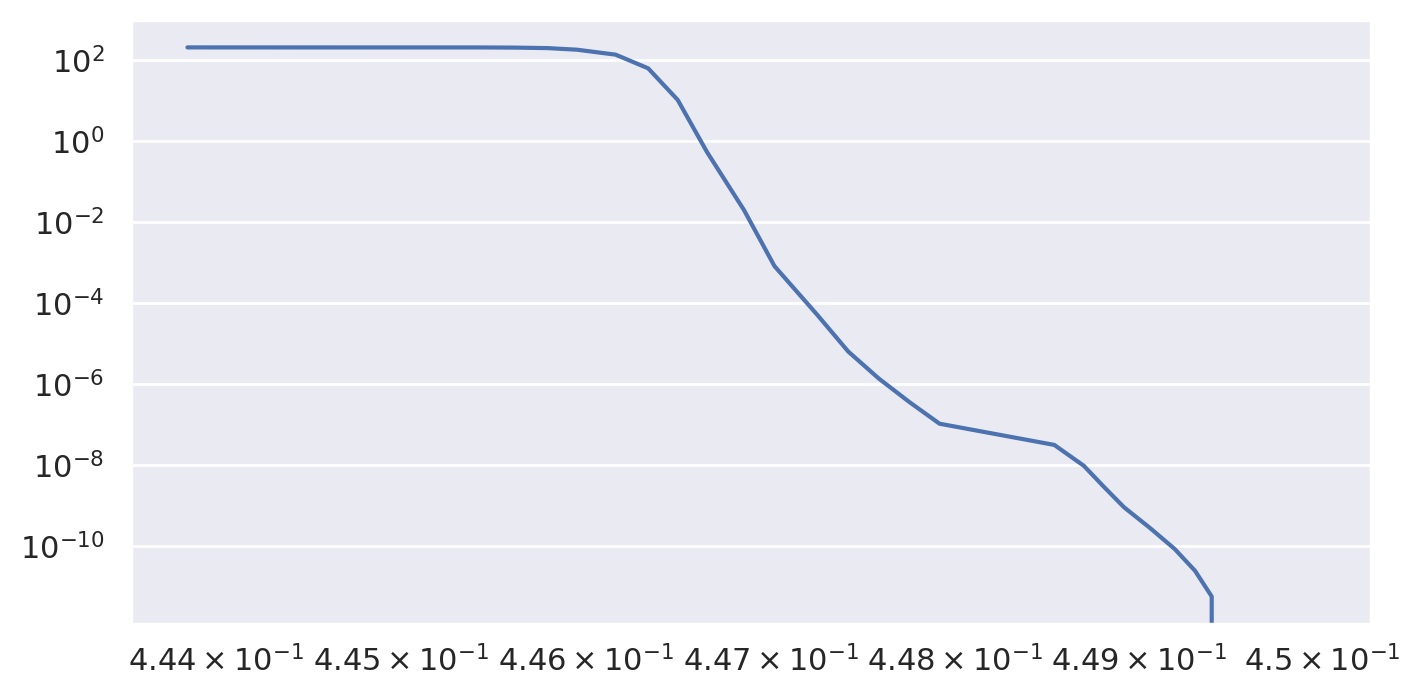

In [28]:
for comp in number_of_components:
    

    pca = PCA(comp)
    pca.fit(np_data)
    final = pca.components_

    mean = (pca.mean_).reshape(1,-1)
    centered_np_data = np_data - mean
    jnp_centered_data = jnp.asarray(centered_np_data, dtype=jnp.float64)
    minimum_loss = np_cost(final.T,centered_np_data)
    print("min_loss", minimum_loss)
    
    r = comp
    n,m = centered_np_data.shape
    np.random.seed(0)
    np_init = qr_method(m,1)
    
    print(np_init)
    
    def fit(params, data, optimizer, epochs):
        @jit 
        def step(params, opt_state, data):

            def cost(params, data):
                def _cost(params, data):
                    return norm(data-params.value * jnp.inner(params.value, data))**2
                #print("a", params.value.shape)
                return vmap(_cost, in_axes=(None,0))(params, data).mean()
            #print("a", data.shape)
            rgrads = rgrad(cost)(params, data) #calculates Riemannian gradients
            updates, opt_state = optimizer.update(rgrads, opt_state, params)
            params = apply_updates(params, updates) #Update using Riemannian Exp
            loss_value = cost(params, data)
            return params, opt_state, loss_value

        opt_state = optimizer.init(params)
        rieoptax_loss = []
        rieoptax_time = []
        start = timer()
        for i in tqdm(range(epochs)):
            params, opt_state, loss_value = step(params, opt_state, data)
            #print(loss_value)
            elapsed_time = timer() - start
            rieoptax_loss.append(loss_value)
            rieoptax_time.append(elapsed_time)
            
        
        return rieoptax_loss, rieoptax_time
        
        #initialization
    print("a", np_init.shape)
    jnp_init = jnp.asarray(np_init[:,0])
    print("a", jnp_init.shape)
    
    U_init = ManifoldArray(value=jnp_init, manifold=HypersphereCanonical(m))
    
    epochs = 30
    lr = 0.002
    optimizer = rsgd(lr)
    rieoptax_loss, rieoptax_time = fit(U_init, jnp_centered_data, optimizer, epochs)
    np.save("rieoptax_loss_{}_Retr.npy".format(1), rieoptax_loss)
    np.save("rieoptax_time_{}_Retr.npy".format(1), rieoptax_time)
    
    
    
   
#     def tf_cost(var, data):
#         n = data.shape[0]
#         diff = tf.transpose( data) - var @ (tf.transpose(var) @ tf.transpose( data))   # m,r @ r,m @ m, n => m,n
#         cost = tf.linalg.norm(diff)**2/n
#         return cost
    
    
#     tf.keras.backend.clear_session()
#     tf.config.optimizer.set_jit(True)
    
#     @tf.function
#     def step(var, data):
#         with tf.GradientTape() as tape:
#             loss = tf_cost(var, data)        
#         grad = tape.gradient(loss, [var])
#         opt.apply_gradients(zip(grad, [var]))
#         return loss
    
#     var = tf.Variable(np_init)
#     Grassman = riemopt.manifolds.grassmannian.Grassmannian()
#     riemopt.variable.assign_to_manifold(var, Grassman)
#     opt = riemopt.optimizers.riemannian_gradient_descent.RiemannianSGD(learning_rate=0.002)

#     data = tf.constant(centered_np_data)
#     print(data.shape)
#     STEPS = 100
#     for _ in range(STEPS):
#         loss = step(var, data)
#         print("lo", loss)

    
    
    
    
    fig, axes = plt.subplots(1, 1, figsize=(8, 4), dpi=200)
    axes.plot(np.asarray(rieoptax_time),  np.asarray(rieoptax_loss) - minimum_loss)
    axes.set_yscale("log")
    axes.set_xscale("log")
    plt.show()
    
    